In [30]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import os

# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configuration dictionary for maintainability
CONFIG = {
    'features': [
        {'name': 'close_lag', 'column': 'Close', 'type': 'lag', 'params': {'lag': [1, 5]}},
        {'name': 'volume_lag', 'column': 'Volume', 'type': 'lag', 'params': {'lag': [1, 5]}},

        {'name': 'close_return', 'column': 'Close', 'type': 'return', 'params': {'lag': [1, 5, 10]}},

        {'name': 'close_ema', 'column': 'Close', 'type': 'ema', 'params': {'span': [12, 26]}},

        {'name': 'rsi', 'column': 'Close', 'type': 'rsi', 'params': {'window': 9}},
        {'name': 'rsi', 'column': 'Close', 'type': 'rsi', 'params': {'window': 14}},

        {'name': 'bollinger', 'column': 'Close', 'type': 'bollinger', 'params': {'window': 10, 'std': 1.5}},
        {'name': 'bollinger', 'column': 'Close', 'type': 'bollinger', 'params': {'window': 10, 'std': 2}},
        {'name': 'bollinger', 'column': 'Close', 'type': 'bollinger', 'params': {'window': 10, 'std': 2.5}},

    ],
    'learning_rate': 0.001,
    'target_column': 'Close',
    'n_steps_in': 50,
    'n_steps_out': 5,
    'epochs':25,
    'batch_size': 16,
    'lstm_units': 100,
    'dropout_rate': 0.1,
    'learning_rate': 0.001,
}

# {'name': 'bollinger', 'column': 'Close', 'type': 'bollinger', 'params': {'window': 20, 'std': 2.5}},
# {'name': 'bollinger', 'column': 'Close', 'type': 'bollinger', 'params': {'window': 20, 'std': 2}},
# {'name': 'bollinger', 'column': 'Close', 'type': 'bollinger', 'params': {'window': 20, 'std': 2}},

# Load data from CSV file
def load_data(file_path):
    try:
        df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
        print(f"Data loaded successfully. Shape: {df.shape}")
        return df
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None

# Feature engineering functions
def create_lag_feature(df, column, lag):
    """Create lagged features (shifted values)"""
    return df[column].shift(lag)

def create_return_feature(df, column, lag):
    """Create return features (percentage change)"""
    return df[column].pct_change(lag, fill_method=None)

def create_ma_feature(df, column, window):
    """Create moving average features"""
    return df[column].rolling(window=window).mean()

def create_ema_feature(df, column, span):
    """Create exponential moving average features"""
    return df[column].ewm(span=span, adjust=False).mean()

def create_rsi_feature(df, column, window):
    """Create Relative Strength Index feature"""
    delta = df[column].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def create_bollinger_feature(df, column, window, std):
    """Create Bollinger Bands features"""
    ma = df[column].rolling(window=window).mean()
    std_dev = df[column].rolling(window=window).std()
    upper_band = ma + (std_dev * std)
    lower_band = ma - (std_dev * std)
    width = (upper_band - lower_band) / ma

    # Return dictionary of features
    return {
        'bb_ma': ma,
        'bb_upper': upper_band,
        'bb_lower': lower_band,
        'bb_width': width
    }

def create_macd_feature(df, column, fast, slow, signal):
    """Create MACD features"""
    ema_fast = df[column].ewm(span=fast, adjust=False).mean()
    ema_slow = df[column].ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    macd_signal = macd.ewm(span=signal, adjust=False).mean()
    macd_hist = macd - macd_signal

    # Return dictionary of features
    return {
        'macd': macd,
        'macd_signal': macd_signal,
        'macd_hist': macd_hist
    }

# Engineer features based on configuration
def engineer_features(df, feature_config):
    """
    Add engineered features based on configuration
    """
    print("Engineering features...")

    # Create a copy to avoid modifying the original
    df_featured = df.copy()

    feature_creators = {
        'lag': create_lag_feature,
        'return': create_return_feature,
        'ma': create_ma_feature,
        'ema': create_ema_feature,
        'rsi': create_rsi_feature,
        'bollinger': create_bollinger_feature,
        'macd': create_macd_feature
    }

    # Process each feature configuration
    for feature in feature_config:
        feature_name = feature['name']
        column = feature['column']
        feature_type = feature['type']
        params = feature['params']

        if column not in df_featured.columns:
            print(f"Warning: Column '{column}' not found in data. Skipping feature '{feature_name}'.")
            continue

        # Check if the feature type is supported
        if feature_type not in feature_creators:
            print(f"Warning: Feature type '{feature_type}' not supported. Skipping feature '{feature_name}'.")
            continue

        print(f"Creating feature: {feature_name} (type: {feature_type})")

        # Process the feature based on its type and parameters
        if feature_type in ['lag', 'return']:
            if isinstance(params['lag'], list):
                for lag in params['lag']:
                    col_name = f"{feature_name}_{lag}"
                    df_featured[col_name] = feature_creators[feature_type](df_featured, column, lag)
            else:
                col_name = f"{feature_name}_{params['lag']}"
                df_featured[col_name] = feature_creators[feature_type](df_featured, column, params['lag'])

        elif feature_type in ['ma', 'ema']:
            param_key = 'window' if feature_type == 'ma' else 'span'
            if isinstance(params[param_key], list):
                for window in params[param_key]:
                    col_name = f"{feature_name}_{window}"
                    df_featured[col_name] = feature_creators[feature_type](df_featured, column, window)
            else:
                col_name = f"{feature_name}_{params[param_key]}"
                df_featured[col_name] = feature_creators[feature_type](df_featured, column, params[param_key])

        elif feature_type == 'rsi':
            col_name = f"{feature_name}_{params['window']}"
            df_featured[col_name] = feature_creators[feature_type](df_featured, column, params['window'])

        elif feature_type == 'bollinger':
            bb_features = feature_creators[feature_type](
                df_featured, column, params['window'], params['std']
            )
            for bb_name, bb_series in bb_features.items():
                df_featured[f"{feature_name}_{bb_name}"] = bb_series

        elif feature_type == 'macd':
            macd_features = feature_creators[feature_type](
                df_featured, column, params['fast'], params['slow'], params['signal']
            )
            for macd_name, macd_series in macd_features.items():
                df_featured[f"{feature_name}_{macd_name}"] = macd_series

    # Drop rows with NaN values after feature engineering
    original_rows = len(df_featured)
    df_featured = df_featured.dropna()

    print(f"Feature engineering complete. Shape before NaN removal: {(original_rows, df_featured.shape[1])}")
    print(f"Final shape: {df_featured.shape}")
    print(f"Rows dropped due to NaN values: {original_rows - len(df_featured)}")

    return df_featured

# Scale data using MinMaxScaler
def scale_data(df, target_col):
    """
    Scale the data and return the scalers for later use
    """
    feature_columns = df.columns.tolist()
    target_idx = feature_columns.index(target_col)

    # Create separate scalers for features and target
    feature_scaler = MinMaxScaler()

    # Scale the data
    scaled_data = feature_scaler.fit_transform(df)

    return scaled_data, feature_scaler, target_idx

# Create input-output sequences for LSTM
def create_sequences(data, n_steps_in, n_steps_out, target_idx, dates=None):
    X, y = [], []
    sequence_dates = []
    target_dates = []

    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i:i + n_steps_in])  # Input sequence
        y.append(data[i + n_steps_in:i + n_steps_in + n_steps_out, target_idx])  # Output sequence (target)

        # If dates are provided, also track corresponding dates
        if dates is not None:
            # Dates for the input sequence
            sequence_dates.append(dates[i:i + n_steps_in])
            # Dates for the target values
            target_dates.append(dates[i + n_steps_in:i + n_steps_in + n_steps_out])

    if dates is not None:
        return np.array(X), np.array(y), sequence_dates, target_dates
    else:
        return np.array(X), np.array(y)

# Build an LSTM model
def build_lstm_model(input_shape, output_dim, units, dropout_rate, learning_rate):
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=input_shape, recurrent_dropout=0.1),
        Dropout(dropout_rate),
        LSTM(units, return_sequences=False, recurrent_dropout=0.1),
        Dropout(dropout_rate),
        Dense(output_dim)  # Output layer for multi-step prediction
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Add config information to plot
def add_config_info(fig, axis_obj, config):
    # Create a string of config info
    features_text = "\n".join([f"- {feat['name']} ({feat['type']})" for feat in config['features'][:5]])
    if len(config['features']) > 5:
        features_text += f"\n- ... and {len(config['features']) - 5} more"

    config_text = "\n".join([
        "Model Configuration:",
        f"Target: {config['target_column']}",
        f"Lookback: {config['n_steps_in']} days",
        f"Predict: {config['n_steps_out']} days",
        f"LSTM units: {config['lstm_units']}",
        f"Dropout: {config['dropout_rate']}",
        f"Learning rate: {config['learning_rate']}",
        "\nFeatures:",
        features_text
    ])

    # Position the text in the top-right corner
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    axis_obj.text(0.98, 0.98, config_text, transform=axis_obj.transAxes, fontsize=8,
                 verticalalignment='top', horizontalalignment='right', bbox=props)

# Plot the model training loss
def plot_loss(history, config):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(history.history['loss'], label='Training Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.set_title('Model Loss During Training')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

    # Add config information
    add_config_info(fig, ax, config)

    # Save figure with timestamp
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    plt.savefig(f'lstm_loss_{timestamp}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot the predicted vs actual values - FIXED function with date printing
def plot_predictions(y_true, y_pred, dates, target_dates, n_steps_out, config):
    fig, axes = plt.subplots(n_steps_out, 1, figsize=(12, 3*n_steps_out))

    if n_steps_out == 1:
        axes = [axes]

    # Plot for each prediction step
    for i in range(n_steps_out):
        # # Print target dates for this step
        # print(f"\nDay {i+1} prediction dates:")

        # Plot using the correct sequence and target dates
        axes[i].plot(dates, y_true[:, i], 'b-', label=f'Actual (t+{i+1})')
        axes[i].plot(dates, y_pred[:, i], 'r--', label=f'Predicted (t+{i+1})')
        axes[i].set_title(f'Day {i+1} Prediction for {config["target_column"]}')
        axes[i].legend()
        axes[i].grid(True)

      axes[i].xaxis.set_major_locator(mdates.YearLocator())
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        fig.autofmt_xdate()

    # Add config information to the first subplot
    add_config_info(fig, axes[0], config)

    plt.tight_layout()
    plt.show()

# Calculate performance metrics
def calculate_metrics(y_true, y_pred):
    results = {}
    for i in range(y_true.shape[1]):
        mse = mean_squared_error(y_true[:, i], y_pred[:, i])
        mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
        results[f'day_{i+1}'] = {'MSE': mse, 'MAE': mae, 'RMSE': np.sqrt(mse)}

    return results

# Load data
df = load_data('data.csv')
cols_to_drop = [col for col in df.columns if col.endswith("prev")]
if cols_to_drop:
  df = df.drop(columns=cols_to_drop)

# Engineer features
df_featured = engineer_features(df, CONFIG['features'])

# Print first few dates of the dataset for reference
print("\n===== DATASET DATES =====")
print(f"Dataset date range: {df_featured.index[0]} to {df_featured.index[-1]}")
print(f"Total dates in dataset: {len(df_featured.index)}")

# Scale data
scaled_data, feature_scaler, target_idx = scale_data(df_featured, CONFIG['target_column'])

# Create sequences with date tracking
X, y, sequence_dates, target_dates = create_sequences(
    scaled_data, CONFIG['n_steps_in'], CONFIG['n_steps_out'], target_idx, df_featured.index
)

# Print sequence details
print("\n===== SEQUENCE CREATION =====")
print(f"Total sequences created: {len(X)}")
print(f"First sequence dates: {sequence_dates[0][0]} to {sequence_dates[0][-1]}")
print(f"First target dates: {target_dates[0][0]} to {target_dates[0][-1]}")

print(f"sequence dates: {sequence_dates[100][0]} to {sequence_dates[100][-1]}")
print(f"target dates: {target_dates[100][0]} to {target_dates[100][-1]}")

print(f"sequence dates: {sequence_dates[1027][0]} to {sequence_dates[1027][-1]}")
print(f"target dates: {target_dates[1027][0]} to {target_dates[1027][-1]}")

# Train-validation-test split
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# Split the date sequences as well
train_seq_dates = sequence_dates[:train_size]
val_seq_dates = sequence_dates[train_size:train_size + val_size]
test_seq_dates = sequence_dates[train_size + val_size:]

train_target_dates = target_dates[:train_size]
val_target_dates = target_dates[train_size:train_size + val_size]
test_target_dates = target_dates[train_size + val_size:]

# Print split information
print("\n===== DATA SPLITS =====")
print(f"Training data: {train_size} sequences")
print(f"Validation data: {val_size} sequences")
print(f"Testing data: {len(X_test)} sequences")

print(f"\nTraining date range: {train_seq_dates[0][0]} to {train_target_dates[-1][-1]}")
print(f"Validation date range: {val_seq_dates[0][0]} to {val_target_dates[-1][-1]}")
print(f"Testing date range: {test_seq_dates[0][0]} to {test_target_dates[-1][-1]}")

print(f"\nTraining data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

# Build model
model = build_lstm_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    output_dim=CONFIG['n_steps_out'],
    units=CONFIG['lstm_units'],
    dropout_rate=CONFIG['dropout_rate'],
    learning_rate=CONFIG['learning_rate']
)

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
]

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=CONFIG['epochs'],
    batch_size=CONFIG['batch_size'],
    callbacks=callbacks,
    verbose=1
)

# Plot training history
plot_loss(history, CONFIG)

# Make predictions
y_pred = model.predict(X_test)

# Get the last date of each input sequence for the test set
test_plot_dates = [dates[-1] for dates in test_seq_dates]

print("\n===== TEST PREDICTION DATES =====")
print(f"Number of test sequences: {len(test_seq_dates)}")


# Calculate metrics
metrics = calculate_metrics(y_test, y_pred)
print("\nModel Performance Metrics:")
for day, scores in metrics.items():
    print(f"{day}: MSE={scores['MSE']:.6f}, MAE={scores['MAE']:.6f}, RMSE={scores['RMSE']:.6f}")

# Plot predictions
plot_predictions(y_test, y_pred, test_plot_dates, test_target_dates, CONFIG['n_steps_out'], CONFIG)

# Save metrics to CSV
metrics_df = pd.DataFrame()
for day, scores in metrics.items():
    for metric, value in scores.items():
        metrics_df.loc[day, metric] = value

timestamp = time.strftime("%Y%m%d-%H%M%S")
metrics_df.to_csv(f'lstm_metrics_{timestamp}.csv')
print(f"Metrics saved to lstm_metrics_{timestamp}.csv")


===== DATASET DATES =====
Dataset date range: 1994-01-20 00:00:00 to 2024-12-27 00:00:00
Total dates in dataset: 6371



===== SEQUENCE CREATION =====
Total sequences created: 6317
First sequence dates: 1994-01-20 00:00:00 to 1994-05-04 00:00:00
First target dates: 1994-05-05 00:00:00 to 1994-05-11 00:00:00
sequence dates: 1994-08-05 00:00:00 to 1994-11-03 00:00:00
target dates: 1994-11-04 00:00:00 to 1994-11-10 00:00:00
sequence dates: 1999-03-01 00:00:00 to 1999-06-02 00:00:00
target dates: 1999-06-03 00:00:00 to 1999-06-09 00:00:00



===== DATA SPLITS =====
Training data: 4421 sequences
Validation data: 947 sequences
Testing data: 949 sequences

Training date range: 1994-01-20 00:00:00 to 2015-08-19 00:00:00
Validation date range: 2015-05-28 00:00:00 to 2020-03-25 00:00:00
Testing date range: 2020-01-07 00:00:00 to 2024-12-27 00:00:00

Training data shape: (4421, 50, 22), (4421, 5)
Validation data shape: (947, 50, 22), (947, 5)
Testing data shape: (949, 50, 22), (949, 5)


Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


277/277 ━━━━━━━━━━━━━━━━━━━━ 23s 67ms/step - loss: 0.0046 - val_loss: 6.9324e-04 - learning_rate: 0.0010
Epoch 2/25
277/277 ━━━━━━━━━━━━━━━━━━━━ 23s 84ms/step - loss: 6.8387e-04 - val_loss: 2.8511e-04 - learning_rate: 0.0010
Epoch 3/25
277/277 ━━━━━━━━━━━━━━━━━━━━ 36s 66ms/step - loss: 5.1139e-04 - val_loss: 2.3480e-04 - learning_rate: 0.0010
Epoch 4/25
277/277 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - loss: 4.6061e-04 - val_loss: 3.1373e-04 - learning_rate: 0.0010
Epoch 5/25
277/277 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - loss: 4.1544e-04 - val_loss: 6.9674e-04 - learning_rate: 0.0010
Epoch 6/25
277/277 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - loss: 3.6320e-04 - val_loss: 2.8878e-04 - learning_rate: 0.0010
Epoch 7/25
277/277 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - loss: 3.5744e-04 - val_loss: 2.7023e-04 - learning_rate: 0.0010
Epoch 8/25
277/277 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - loss: 2.9192e-04 - val_loss: 2.0666e-04 - learning_rate: 5.0000e-04
Epoch 9/25
277/277 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/st

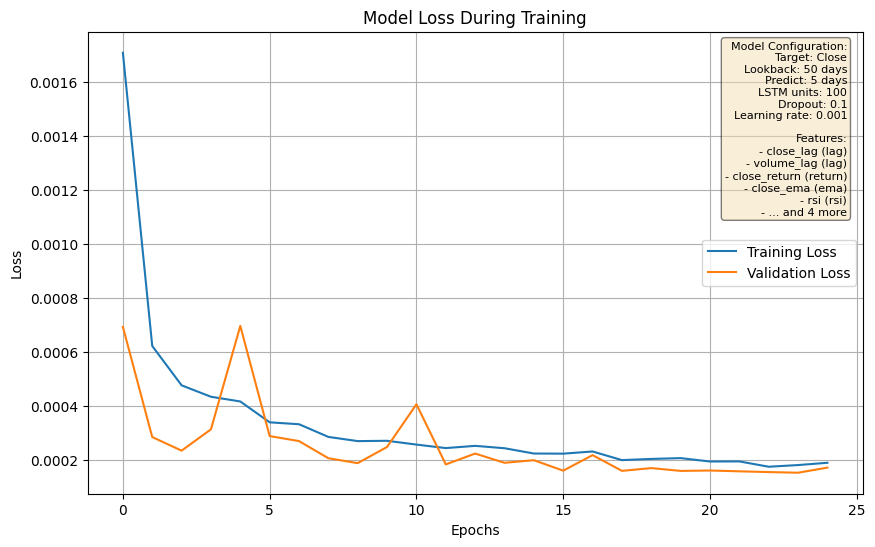

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


In [26]:
# Get the last date of each input sequence for the test set
test_plot_dates = [dates[-1] for dates in test_seq_dates]

print("\n===== TEST PREDICTION DATES =====")
print(f"Number of test sequences: {len(test_seq_dates)}")
# print(f"First 3 test sequence end dates: {test_plot_dates[:3]}")


===== TEST PREDICTION DATES =====
Number of test sequences: 949



Model Performance Metrics:
day_1: MSE=0.001787, MAE=0.030284, RMSE=0.042271
day_2: MSE=0.001968, MAE=0.031908, RMSE=0.044367
day_3: MSE=0.002302, MAE=0.034592, RMSE=0.047981
day_4: MSE=0.002426, MAE=0.035299, RMSE=0.049251
day_5: MSE=0.002681, MAE=0.036915, RMSE=0.051781


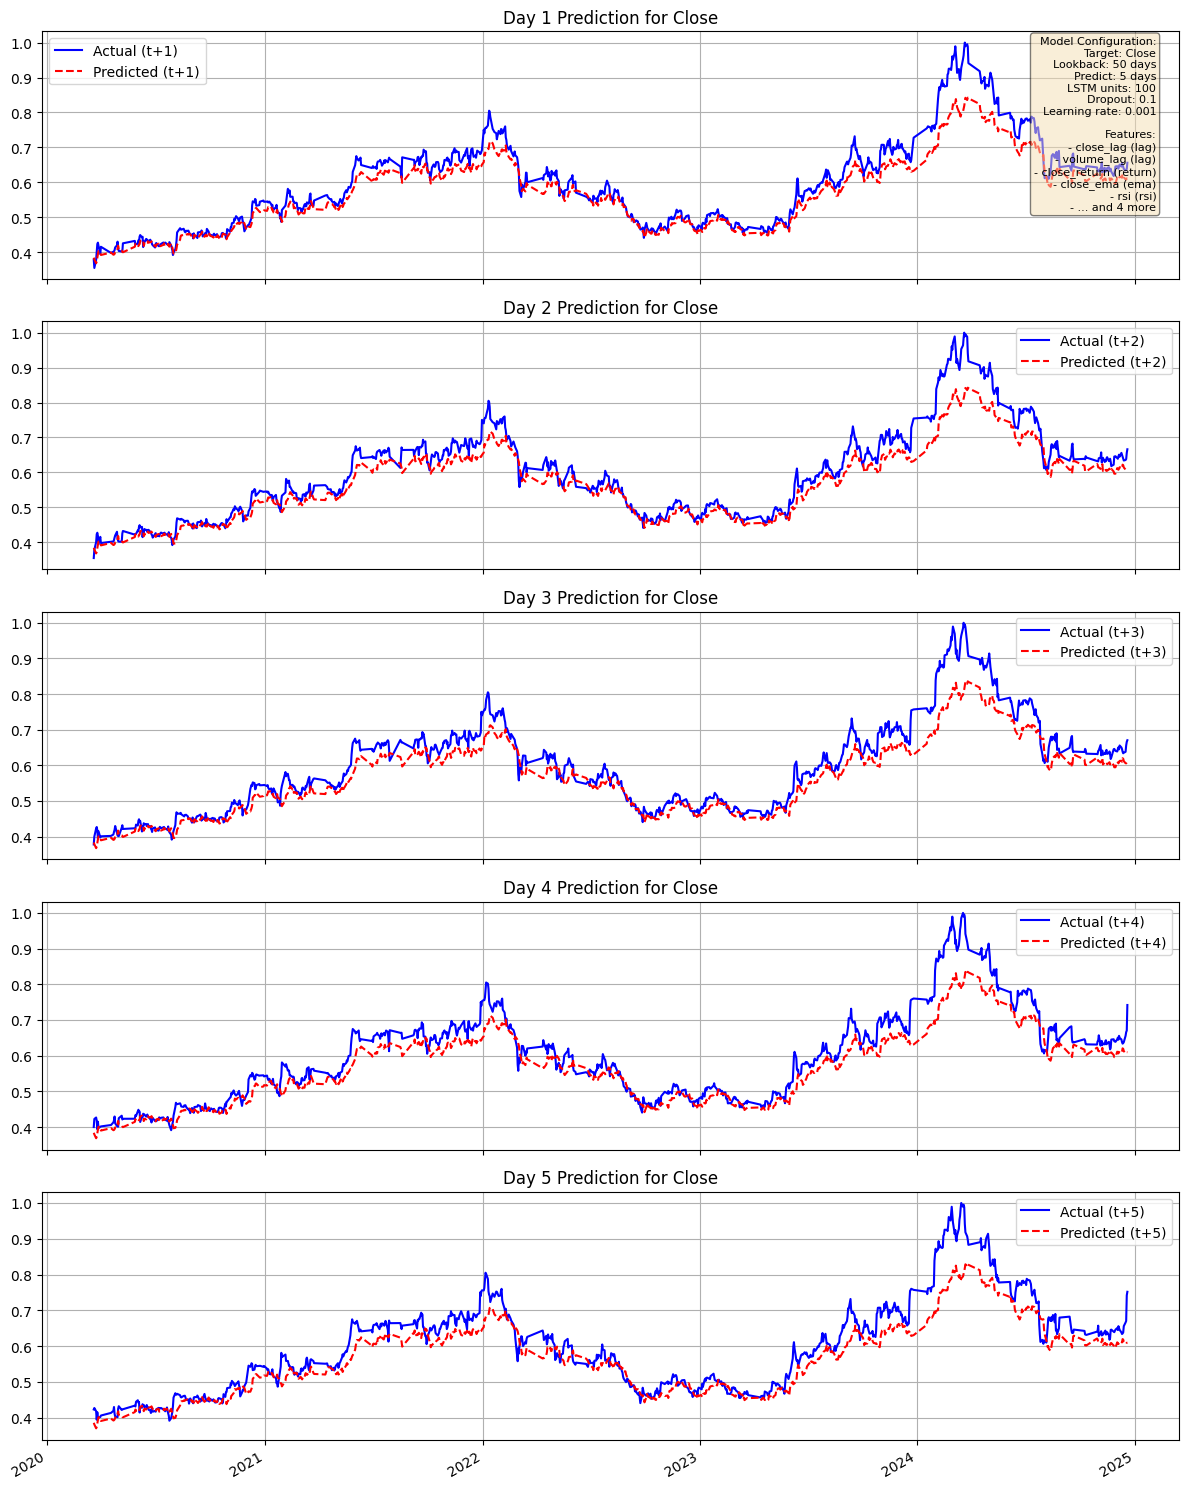

Metrics saved to lstm_metrics_20250309-234503.csv


In [31]:
# Calculate metrics
metrics = calculate_metrics(y_test, y_pred)
print("\nModel Performance Metrics:")
for day, scores in metrics.items():
    print(f"{day}: MSE={scores['MSE']:.6f}, MAE={scores['MAE']:.6f}, RMSE={scores['RMSE']:.6f}")

# Plot predictions
plot_predictions(y_test, y_pred, test_plot_dates, test_target_dates, CONFIG['n_steps_out'], CONFIG)

# Save metrics to CSV
metrics_df = pd.DataFrame()
for day, scores in metrics.items():
    for metric, value in scores.items():
        metrics_df.loc[day, metric] = value

timestamp = time.strftime("%Y%m%d-%H%M%S")
metrics_df.to_csv(f'lstm_metrics_{timestamp}.csv')
print(f"Metrics saved to lstm_metrics_{timestamp}.csv")

In [ ]:
# PARAM_GRID = {
#     'n_steps_in': [20],
#     'lstm_units': [50],
#     'dropout_rate': [0.2],
#     'learning_rate': [0.001],
#     'batch_size': [32]
# }

In [ ]:
# Base configuration dictionary
BASE_CONFIG = {
    'features': [
        {'name': 'close_lag', 'column': 'Close', 'type': 'lag', 'params': {'lag': [1, 3, 5]}},
        {'name': 'volume_lag', 'column': 'Volume', 'type': 'lag', 'params': {'lag': [1, 3, 5]}},
        {'name': 'close_return', 'column': 'Close', 'type': 'return', 'params': {'lag': [1, 5, 10]}},
        {'name': 'close_ma', 'column': 'Close', 'type': 'ma', 'params': {'window': [5, 10, 20]}},
        {'name': 'close_ema', 'column': 'Close', 'type': 'ema', 'params': {'span': [12, 26]}},
        {'name': 'rsi', 'column': 'Close', 'type': 'rsi', 'params': {'window': 14}},
        {'name': 'bollinger', 'column': 'Close', 'type': 'bollinger', 'params': {'window': 20, 'std': 2}},
        {'name': 'macd', 'column': 'Close', 'type': 'macd', 'params': {'fast': 12, 'slow': 26, 'signal': 9}}
    ],
    'n_steps_in': 20,  # Lookback period for LSTM
    'n_steps_out': 5,  # Predict the next 5 days
    'epochs': 1,  # Number of epochs to train
    'batch_size': 32,  # Batch size for training
    'lstm_units': 50,  # LSTM units in each layer
    'dropout_rate': 0.2,  # Dropout rate to prevent overfitting
    'learning_rate': 0.001,
    'target_column': 'Close'  # Column to predict
}

# Parameter grid for hyperparameter optimization
PARAM_GRID = {
    'n_steps_in': [10, 20, 30],
    'lstm_units': [32, 50, 100],
    'dropout_rate': [0.1, 0.2, 0.3],
    'learning_rate': [0.01, 0.001, 0.0001],
    'batch_size': [16, 32, 64]
}

# Load data from CSV file
def load_data(file_path):
    try:
        df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
        print(f"Data loaded successfully. Shape: {df.shape}")
        return df
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None

# Calculate performance metrics
def calculate_metrics(y_true, y_pred):
    results = {}
    overall_mse = mean_squared_error(y_true.flatten(), y_pred.flatten())
    overall_mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
    overall_rmse = np.sqrt(overall_mse)

    results['overall'] = {'MSE': overall_mse, 'MAE': overall_mae, 'RMSE': overall_rmse}

    for i in range(y_true.shape[1]):
        mse = mean_squared_error(y_true[:, i], y_pred[:, i])
        mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
        results[f'day_{i+1}'] = {'MSE': mse, 'MAE': mae, 'RMSE': np.sqrt(mse)}

    return results

# Function to train and evaluate a single model configuration
def evaluate_model(config, X_train, y_train, X_val, y_val):
    # Set random seeds for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)

    # Build model
    model = build_lstm_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        output_dim=config['n_steps_out'],
        units=config['lstm_units'],
        dropout_rate=config['dropout_rate'],
        learning_rate=config['learning_rate']
    )

    # Define callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]

    # Measure training time
    start_time = time.time()

    # Train model with early stopping
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        callbacks=callbacks,
        verbose=0  # Silent training for grid search
    )

    # Calculate training time
    training_time = time.time() - start_time

    # Get the best validation loss
    best_val_loss = min(history.history['val_loss'])

    # Make predictions on validation set
    y_val_pred = model.predict(X_val, verbose=0)

    # Calculate metrics
    val_metrics = calculate_metrics(y_val, y_val_pred)

    # Record results
    result = {
        'config': {k: v for k, v in config.items() if k in PARAM_GRID},
        'best_val_loss': best_val_loss,
        'val_rmse_overall': val_metrics['overall']['RMSE'],
        'val_mae_overall': val_metrics['overall']['MAE'],
        'epochs_used': len(history.history['loss']),
        'training_time': training_time
    }

    # Clear TF session to prevent memory leaks
    tf.keras.backend.clear_session()

    return result

# Generate grid of hyperparameters to test
def generate_param_grid(param_grid):
    keys = param_grid.keys()
    values = param_grid.values()
    for combination in product(*values):
        yield dict(zip(keys, combination))

# Run Bayesian optimization (simulated with a smarter search strategy)
def smart_search(base_config, param_grid, X_train, y_train, X_val, y_val, max_evals=20):
    # Start with a basic grid search with fewer combinations
    results = []

    # Create a directory for results if it doesn't exist
    if not os.path.exists('optimization_results'):
        os.makedirs('optimization_results')

    # Phase 1: Initial grid search with fewer combinations
    # Sample a smaller grid to get started
    reduced_grid = {
        'n_steps_in': [20],
        'lstm_units': [50],
        'dropout_rate': [0.2],
        'learning_rate': [0.001],
        'batch_size': [32]
    }

    # Keep track of the best config and score
    best_config = None
    best_score = float('inf')

    print("Phase 1: Initial exploration...")

    # Test initial configurations
    for params in generate_param_grid(reduced_grid):
        # Update config with current parameters
        current_config = base_config.copy()
        current_config.update(params)

        # Evaluate the model
        result = evaluate_model(current_config, X_train, y_train, X_val, y_val)
        results.append(result)

        # Update best configuration if needed
        if result['val_rmse_overall'] < best_score:
            best_score = result['val_rmse_overall']
            best_config = params

        print(f"Config: {params}")
        print(f"RMSE: {result['val_rmse_overall']:.6f}, Time: {result['training_time']:.2f}s")

    # Phase 2: Smart search around the best configuration
    print("\nPhase 2: Refined search around best configuration...")

    # Determine which parameters to explore further
    if best_config:
        # For each parameter, try values near the best one
        remaining_evals = max_evals - len(results)

        # Create exploration sets for each parameter
        for param_name, param_values in param_grid.items():
            if remaining_evals <= 0:
                break

            # Get the best value for this parameter
            best_value = best_config[param_name]

            # Get index of the best value in the parameter grid
            try:
                idx = param_values.index(best_value)
            except ValueError:
                # If value not in grid, find closest one
                idx = min(range(len(param_values)), key=lambda i: abs(param_values[i] - best_value))

            # Try neighboring values
            for offset in [-1, 1]:
                new_idx = idx + offset
                if 0 <= new_idx < len(param_values):
                    # Create new config with this parameter changed
                    new_config = best_config.copy()
                    new_config[param_name] = param_values[new_idx]

                    # Only evaluate if we haven't already tried this configuration
                    if not any(new_config == r['config'] for r in results):
                        # Update config with current parameters
                        current_config = base_config.copy()
                        current_config.update(new_config)

                        # Evaluate the model
                        result = evaluate_model(current_config, X_train, y_train, X_val, y_val)
                        results.append(result)

                        # Update best configuration if needed
                        if result['val_rmse_overall'] < best_score:
                            best_score = result['val_rmse_overall']
                            best_config = new_config

                        print(f"Config: {new_config}")
                        print(f"RMSE: {result['val_rmse_overall']:.6f}, Time: {result['training_time']:.2f}s")

                        remaining_evals -= 1
                        if remaining_evals <= 0:
                            break

    # Phase 3: Final exploration
    print("\nPhase 3: Final exploration of promising configurations...")

    # Sort results by performance
    sorted_results = sorted(results, key=lambda x: x['val_rmse_overall'])

    # Try some combinations of the best parameters
    if remaining_evals > 0:
        # Get the top 3 configs
        top_configs = sorted_results[:min(3, len(sorted_results))]

        # Create new configs by combining attributes from the top performers
        for i in range(min(remaining_evals, 5)):
            # Create a new config
            new_config = {}

            # For each parameter, randomly choose from one of the top configs
            for param_name in param_grid.keys():
                # Randomly select which top config to use for this parameter
                random_top_config = np.random.choice(top_configs)
                new_config[param_name] = random_top_config['config'][param_name]

            # Only evaluate if we haven't already tried this configuration
            if not any(new_config == r['config'] for r in results):
                # Update config with current parameters
                current_config = base_config.copy()
                current_config.update(new_config)

                # Evaluate the model
                result = evaluate_model(current_config, X_train, y_train, X_val, y_val)
                results.append(result)

                # Update best configuration if needed
                if result['val_rmse_overall'] < best_score:
                    best_score = result['val_rmse_overall']
                    best_config = new_config

                print(f"Config: {new_config}")
                print(f"RMSE: {result['val_rmse_overall']:.6f}, Time: {result['training_time']:.2f}s")

    # Save all results to a file
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    with open(f'optimization_results/all_results_{timestamp}.json', 'w') as f:
        json.dump(results, f, indent=2)

    # Sort and return the best configurations
    sorted_results = sorted(results, key=lambda x: x['val_rmse_overall'])

    return sorted_results

# Train the final model with the best configuration
def train_final_model(best_config, X_train, y_train, X_val, y_val, X_test, y_test, test_dates):
    print(f"\nTraining final model with best configuration: {best_config}")

    # Set random seeds for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)

    # Build model
    model = build_lstm_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        output_dim=best_config['n_steps_out'],
        units=best_config['lstm_units'],
        dropout_rate=best_config['dropout_rate'],
        learning_rate=best_config['learning_rate']
    )

    # Define callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=best_config['epochs'],
        batch_size=best_config['batch_size'],
        callbacks=callbacks,
        verbose=1
    )

    # Make predictions on test set
    y_pred = model.predict(X_test)

    # Calculate metrics
    metrics = calculate_metrics(y_test, y_pred)
    print("\nFinal Model Performance Metrics:")
    print(f"Overall: MSE={metrics['overall']['MSE']:.6f}, MAE={metrics['overall']['MAE']:.6f}, RMSE={metrics['overall']['RMSE']:.6f}")
    for day, scores in metrics.items():
        if day != 'overall':
            print(f"{day}: MSE={scores['MSE']:.6f}, MAE={scores['MAE']:.6f}, RMSE={scores['RMSE']:.6f}")

    # Plot predictions for the final model
    plot_predictions(y_test, y_pred, test_dates, best_config['n_steps_out'], best_config)

    # Save metrics to CSV
    metrics_df = pd.DataFrame()
    for day, scores in metrics.items():
        for metric, value in scores.items():
            metrics_df.loc[day, metric] = value

    timestamp = time.strftime("%Y%m%d-%H%M%S")
    metrics_df.to_csv(f'final_lstm_metrics_{timestamp}.csv')
    print(f"Metrics saved to final_lstm_metrics_{timestamp}.csv")

    # Save the model
    model.save(f'best_lstm_model_{timestamp}')
    print(f"Model saved to best_lstm_model_{timestamp}")

    return model, metrics

# Plot the optimization results
def plot_optimization_results(results):
    # Convert results to DataFrame for easier plotting
    results_df = pd.DataFrame([
        {
            'RMSE': r['val_rmse_overall'],
            'MAE': r['val_mae_overall'],
            'Time (s)': r['training_time'],
            'n_steps_in': r['config']['n_steps_in'],
            'lstm_units': r['config']['lstm_units'],
            'dropout_rate': r['config']['dropout_rate'],
            'learning_rate': r['config']['learning_rate'],
            'batch_size': r['config']['batch_size']
        }
        for r in results
    ])

    # Create a figure with subplots
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    axes = axes.flatten()

    # Plot RMSE vs different hyperparameters
    params = ['n_steps_in', 'lstm_units', 'dropout_rate', 'learning_rate', 'batch_size']

    for i, param in enumerate(params):
        axes[i].scatter(results_df[param], results_df['RMSE'])
        axes[i].set_xlabel(param)
        axes[i].set_ylabel('Validation RMSE')
        axes[i].set_title(f'RMSE vs {param}')
        axes[i].grid(True)

    # Plot training time distribution in the last subplot
    axes[5].hist(results_df['Time (s)'], bins=10)
    axes[5].set_xlabel('Training Time (s)')
    axes[5].set_ylabel('Frequency')
    axes[5].set_title('Distribution of Training Times')
    axes[5].grid(True)

    plt.tight_layout()

    # Save figure with timestamp
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    plt.savefig(f'optimization_results/hyperparameter_analysis_{timestamp}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Create a table of the top 5 configurations
    top_configs = results_df.sort_values('RMSE').head(5)
    print("\nTop 5 Configurations:")
    print(top_configs[['RMSE', 'MAE', 'Time (s)', 'n_steps_in', 'lstm_units', 'dropout_rate', 'learning_rate', 'batch_size']])

    return top_configs

# Main execution function
def main():
    # Create output directory
    if not os.path.exists('optimization_results'):
        os.makedirs('optimization_results')

    # Set up logging
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    log_file = f'optimization_results/optimization_log_{timestamp}.txt'

    # Start the timer for the whole process
    overall_start_time = time.time()

    # Record start time
    print(f"Starting hyperparameter optimization at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Log file: {log_file}")

    # Load data
    df = load_data('cleaned_data.csv')
    if df is None:
        return

    # Engineer features - do this once for efficiency
    print("Engineering features...")
    df_featured = engineer_features(df, BASE_CONFIG['features'])

    # Scale data
    print("Scaling data...")
    scaled_data, feature_scaler, target_idx = scale_data(df_featured, BASE_CONFIG['target_column'])

    # Create a master dataset for all configurations - will reuse for each config
    # Use the maximum n_steps_in from the parameter grid
    max_n_steps_in = max(PARAM_GRID['n_steps_in'])
    max_n_steps_out = BASE_CONFIG['n_steps_out']

    # Create sequences with max lookback period
    X_master, y_master = create_sequences(scaled_data, max_n_steps_in, max_n_steps_out, target_idx)

    # Train-validation-test split
    train_size = int(len(X_master) * 0.7)
    val_size = int(len(X_master) * 0.15)

    X_train_master = X_master[:train_size]
    y_train_master = y_master[:train_size]
    X_val_master = X_master[train_size:train_size + val_size]
    y_val_master = y_master[train_size:train_size + val_size]
    X_test_master = X_master[train_size + val_size:]
    y_test_master = y_master[train_size + val_size:]

    print(f"Master training data shape: {X_train_master.shape}, {y_train_master.shape}")
    print(f"Master validation data shape: {X_val_master.shape}, {y_val_master.shape}")
    print(f"Master testing data shape: {X_test_master.shape}, {y_test_master.shape}")

    # Run hyperparameter optimization
    print("\nStarting hyperparameter optimization...")
    print(f"Parameter grid: {PARAM_GRID}")
    print(f"Max evaluations: 20")

    all_results = []

    # Function to prepare data for specific n_steps_in
    def prepare_data_for_n_steps(n_steps_in, X_data, y_data):
        # If n_steps_in is the same as the max, return the data as is
        if n_steps_in == max_n_steps_in:
            return X_data, y_data

        # Otherwise, trim the sequences to the desired lookback period
        offset = max_n_steps_in - n_steps_in
        return X_data[:, offset:, :], y_data

    # Run the optimization
    results = smart_search(
        BASE_CONFIG,
        PARAM_GRID,
        X_train_master,
        y_train_master,
        X_val_master,
        y_val_master,
        max_evals=20
    )

    # Plot and analyze the optimization results
    top_configs = plot_optimization_results(results)
main()



```
Starting hyperparameter optimization at 2025-03-09 09:28:00
Log file: optimization_results/optimization_log_20250309-092800.txt
Data loaded successfully. Shape: (1901, 5)
Engineering features...
Scaling data...
Master training data shape: (1293, 30, 27), (1293, 5)
Master validation data shape: (277, 30, 27), (277, 5)
Master testing data shape: (278, 30, 27), (278, 5)

Starting hyperparameter optimization...
Parameter grid: {'n_steps_in': [10, 20, 30], 'lstm_units': [32, 50, 100], 'dropout_rate': [0.1, 0.2, 0.3], 'learning_rate': [0.01, 0.001, 0.0001], 'batch_size': [16, 32, 64]}
Max evaluations: 20
Phase 1: Initial exploration...
Config: {'n_steps_in': 20, 'lstm_units': 50, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}
RMSE: 0.032629, Time: 92.55s

Phase 2: Refined search around best configuration...
Config: {'n_steps_in': 10, 'lstm_units': 50, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}
RMSE: 0.032597, Time: 86.06s
Config: {'n_steps_in': 30, 'lstm_units': 50, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}
RMSE: 0.031961, Time: 91.78s
Config: {'n_steps_in': 30, 'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}
RMSE: 0.032195, Time: 65.68s
Config: {'n_steps_in': 30, 'lstm_units': 100, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}
RMSE: 0.029841, Time: 128.24s
Config: {'n_steps_in': 30, 'lstm_units': 100, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32}
RMSE: 0.029103, Time: 141.72s
Config: {'n_steps_in': 30, 'lstm_units': 100, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32}
RMSE: 0.031998, Time: 87.10s
Config: {'n_steps_in': 30, 'lstm_units': 100, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32}
RMSE: 0.028367, Time: 138.00s
Config: {'n_steps_in': 30, 'lstm_units': 100, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'batch_size': 32}
RMSE: 0.034863, Time: 155.42s
Config: {'n_steps_in': 30, 'lstm_units': 100, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16}
RMSE: 0.028810, Time: 160.50s
Config: {'n_steps_in': 30, 'lstm_units': 100, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 64}
RMSE: 0.030710, Time: 103.21s

Phase 3: Final exploration of promising configurations...
Config: {'n_steps_in': 30, 'lstm_units': 100, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 16}
RMSE: 0.027573, Time: 251.99s

Top 5 Configurations:
       RMSE       MAE    Time (s)  n_steps_in  lstm_units  dropout_rate  \
0  0.027573  0.020835  251.989798          30         100           0.1   
1  0.028367  0.020920  138.000569          30         100           0.1   
2  0.028810  0.020985  160.499642          30         100           0.1   
3  0.029103  0.022413  141.724328          30         100           0.1   
4  0.029841  0.022877  128.243404          30         100           0.2   

   learning_rate  batch_size  
0          0.001          16  
1          0.010          32  
2          0.010          16  
3          0.001          32  
4          0.001          32
```



Data loaded successfully. Shape: (1901, 5)
Starting feature selection process...

Baseline: Evaluating model with all features...
Engineering features...
Creating feature: close_lag (type: lag)
Creating feature: volume_lag (type: lag)
Creating feature: close_return (type: return)
Creating feature: close_ma (type: ma)
Creating feature: close_ema (type: ema)
Creating feature: rsi (type: rsi)
Creating feature: bollinger (type: bollinger)
Creating feature: macd (type: macd)
Feature engineering complete. Shape before NaN removal: (1901, 27)
Final shape: (1882, 27)
Rows dropped due to NaN values: 19
Baseline (All Features): RMSE = 0.033887, Time = 66.51s, Features = 8

Phase 1: Testing importance of individual features...
Engineering features...
Creating feature: volume_lag (type: lag)
Creating feature: close_return (type: return)
Creating feature: close_ma (type: ma)
Creating feature: close_ema (type: ema)
Creating feature: rsi (type: rsi)
Creating feature: bollinger (type: bollinger)
Creat

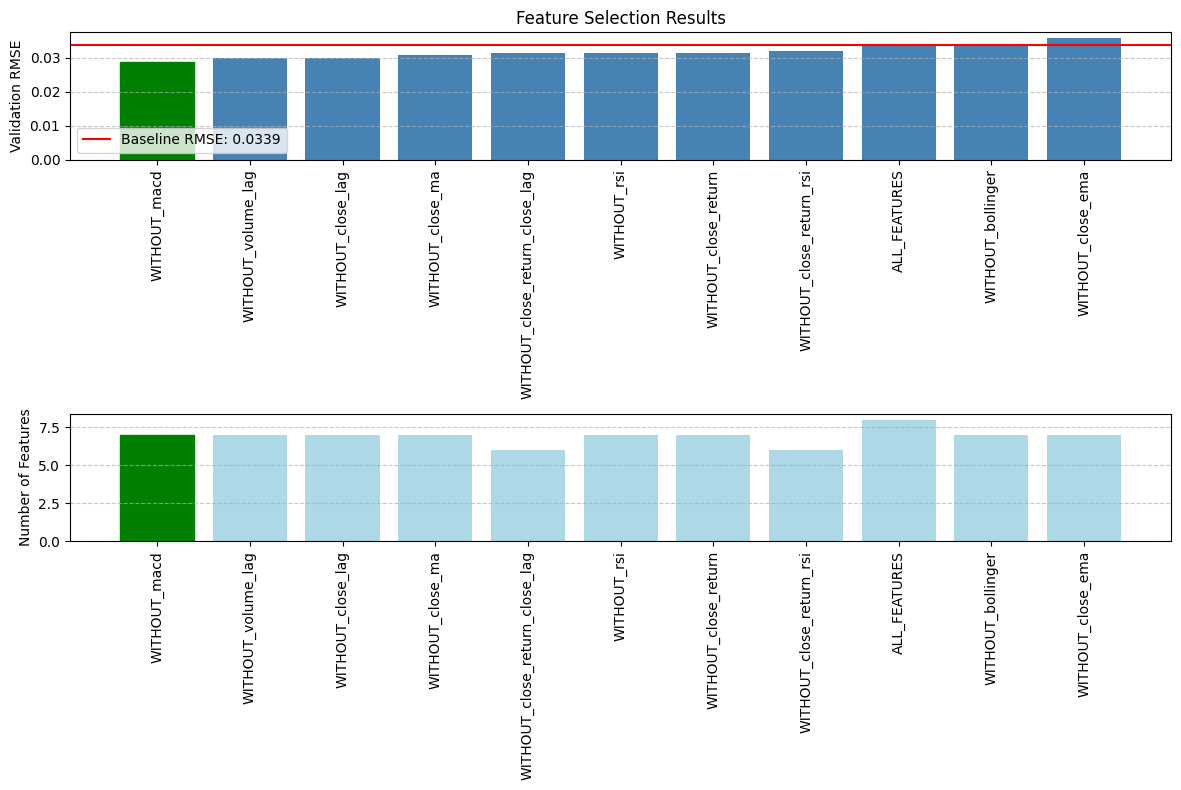


Final optimal feature set determined:
- close_lag
- volume_lag
- close_return
- close_ma
- close_ema
- rsi
- bollinger

You can now train a final model using only these features to balance performance and efficiency.


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from itertools import combinations

# Your optimal hyperparameters
BEST_CONFIG = {
    'n_steps_in': 30,
    'n_steps_out': 5,
    'epochs': 50,
    'batch_size': 16,
    'lstm_units': 100,
    'dropout_rate': 0.1,
    'learning_rate': 0.001,
    'target_column': 'Close'
}

# Feature selection using recursive feature elimination approach
def select_best_features(df, best_config, features_list, max_iterations=5):
    """
    Iteratively evaluate different feature subsets to find the optimal combination.

    Args:
        df: DataFrame with raw data
        best_config: Dictionary with best hyperparameters
        features_list: List of feature dictionaries
        max_iterations: Maximum number of iterations for feature testing

    Returns:
        best_features: List of the best performing features
        results: Dictionary of evaluation results
    """
    print("Starting feature selection process...")

    # Create a results tracker
    feature_results = {}

    # Track base performance with all features
    print("\nBaseline: Evaluating model with all features...")

    # Engineer all features
    all_features_df = engineer_features(df, features_list)

    # Scale the data
    scaled_data, feature_scaler, target_idx = scale_data(all_features_df, best_config['target_column'])

    # Create sequences
    X, y = create_sequences(scaled_data, best_config['n_steps_in'],
                           best_config['n_steps_out'], target_idx)

    # Train-validation-test split
    train_size = int(len(X) * 0.7)
    val_size = int(len(X) * 0.15)

    X_train = X[:train_size]
    y_train = y[:train_size]
    X_val = X[train_size:train_size + val_size]
    y_val = y[train_size:train_size + val_size]

    # Evaluate with all features as baseline
    baseline_result = evaluate_quick(best_config, X_train, y_train, X_val, y_val)

    # Log baseline performance
    all_feature_names = [f['name'] for f in features_list]
    feature_key = "ALL_FEATURES"
    feature_results[feature_key] = {
        'features': all_feature_names,
        'num_features': len(all_feature_names),
        'val_rmse': baseline_result['val_rmse_overall'],
        'training_time': baseline_result['training_time']
    }

    print(f"Baseline (All Features): RMSE = {baseline_result['val_rmse_overall']:.6f}, "
          f"Time = {baseline_result['training_time']:.2f}s, "
          f"Features = {len(all_feature_names)}")

    # Initial feature importance test - one feature at a time
    print("\nPhase 1: Testing importance of individual features...")

    # Test removing each feature group
    for feat_idx, feature in enumerate(features_list):
        # Create a feature list without this feature
        reduced_features = [f for i, f in enumerate(features_list) if i != feat_idx]
        feature_name = feature['name']

        # Engineer features excluding this one
        reduced_df = engineer_features(df, reduced_features)

        # Scale the data
        scaled_data, feat_scaler, tgt_idx = scale_data(reduced_df, best_config['target_column'])

        # Create sequences
        X_red, y_red = create_sequences(scaled_data, best_config['n_steps_in'],
                                      best_config['n_steps_out'], tgt_idx)

        # Split data
        X_train_red = X_red[:train_size]
        y_train_red = y_red[:train_size]
        X_val_red = X_red[train_size:train_size + val_size]
        y_val_red = y_red[train_size:train_size + val_size]

        # Evaluate model
        result = evaluate_quick(best_config, X_train_red, y_train_red, X_val_red, y_val_red)

        # Record results
        removed_feature_key = f"WITHOUT_{feature_name}"
        remaining_features = [f['name'] for f in reduced_features]
        feature_results[removed_feature_key] = {
            'features': remaining_features,
            'num_features': len(remaining_features),
            'val_rmse': result['val_rmse_overall'],
            'training_time': result['training_time'],
            'impact': result['val_rmse_overall'] - baseline_result['val_rmse_overall']
        }

        print(f"Without {feature_name}: RMSE = {result['val_rmse_overall']:.6f}, "
              f"Impact = {feature_results[removed_feature_key]['impact']:.6f}, "
              f"Time = {result['training_time']:.2f}s")

    # Analyze initial results to identify feature importance
    print("\nPhase 2: Analyzing feature importance...")
    impact_results = {k: v for k, v in feature_results.items() if k != "ALL_FEATURES"}

    # Sort features by their impact - higher impact means more important
    sorted_features = sorted(impact_results.items(), key=lambda x: x[1]['impact'], reverse=True)

    # Features with negative impact are candidates for removal (model performs better without them)
    candidates_for_removal = [feat_name.replace("WITHOUT_", "") for feat_name, data in sorted_features
                            if data['impact'] < 0]

    # Phase 3: Test different combinations of the most important features
    print(f"\nPhase 3: Testing feature combinations...")
    print(f"Candidates for removal: {candidates_for_removal}")

    # Start with all features and progressively remove less important ones
    current_features = features_list.copy()

    # Try removing combinations of features with negative impact
    if candidates_for_removal:
        print("Testing removal combinations...")

        # Try removing combinations of 1, 2, or 3 features at a time (up to the number of candidates)
        max_to_remove = min(3, len(candidates_for_removal))

        for num_to_remove in range(1, max_to_remove + 1):
            for combo in combinations(candidates_for_removal, num_to_remove):
                # Skip if we've exceeded max iterations
                if len(feature_results) >= max_iterations + 1:  # +1 for baseline
                    print(f"Reached maximum iterations ({max_iterations}). Stopping feature testing.")
                    break

                # Create feature set without these features
                reduced_features = [f for f in features_list
                                  if f['name'] not in combo]

                if not reduced_features:
                    continue  # Skip empty feature sets

                # Engineer features with this combination
                reduced_df = engineer_features(df, reduced_features)

                # Scale the data
                scaled_data, feat_scaler, tgt_idx = scale_data(reduced_df, best_config['target_column'])

                # Create sequences
                X_red, y_red = create_sequences(scaled_data, best_config['n_steps_in'],
                                              best_config['n_steps_out'], tgt_idx)

                # Split data
                X_train_red = X_red[:train_size]
                y_train_red = y_red[:train_size]
                X_val_red = X_red[train_size:train_size + val_size]
                y_val_red = y_red[train_size:train_size + val_size]

                # Evaluate model
                result = evaluate_quick(best_config, X_train_red, y_train_red, X_val_red, y_val_red)

                # Record results
                combo_key = f"WITHOUT_{'_'.join(combo)}"
                remaining_features = [f['name'] for f in reduced_features]
                feature_results[combo_key] = {
                    'features': remaining_features,
                    'num_features': len(remaining_features),
                    'val_rmse': result['val_rmse_overall'],
                    'training_time': result['training_time'],
                    'impact': result['val_rmse_overall'] - baseline_result['val_rmse_overall']
                }

                print(f"Without {', '.join(combo)}: RMSE = {result['val_rmse_overall']:.6f}, "
                      f"Impact = {feature_results[combo_key]['impact']:.6f}, "
                      f"Time = {result['training_time']:.2f}s")

    # Find the best feature combination based on balance of RMSE and training time
    print("\nIdentifying optimal feature set...")

    # Sort by RMSE (primary criterion)
    sorted_configs = sorted(feature_results.items(), key=lambda x: x[1]['val_rmse'])

    # Find the configuration with the best RMSE
    best_rmse_config = sorted_configs[0]

    # Find configurations with acceptable RMSE (within 5% of the best)
    threshold = best_rmse_config[1]['val_rmse'] * 1.05
    acceptable_configs = [config for config in sorted_configs
                        if config[1]['val_rmse'] <= threshold]

    # Among acceptable configs, find the one with fewest features
    if acceptable_configs:
        best_config_name = min(acceptable_configs, key=lambda x: x[1]['num_features'])[0]
        best_feature_set = feature_results[best_config_name]
    else:
        best_config_name = best_rmse_config[0]
        best_feature_set = feature_results[best_config_name]

    print("\nResults Summary:")
    print(f"Baseline (All Features): RMSE = {feature_results['ALL_FEATURES']['val_rmse']:.6f}, "
          f"Features = {len(feature_results['ALL_FEATURES']['features'])}")

    print(f"Best Feature Set: {best_config_name}")
    print(f"  RMSE: {best_feature_set['val_rmse']:.6f}")
    print(f"  Features: {best_feature_set['num_features']} ({', '.join(best_feature_set['features'])})")
    print(f"  Training Time: {best_feature_set['training_time']:.2f}s")

    if 'impact' in best_feature_set:
        print(f"  RMSE Impact: {best_feature_set['impact']:.6f}")

    # Create visualization of results
    plot_feature_selection_results(feature_results, baseline_result['val_rmse_overall'])

    return best_feature_set['features'], feature_results

# Simplified version of evaluate_model for faster iterations during feature selection
def evaluate_quick(config, X_train, y_train, X_val, y_val, early_stopping=True):
    """Faster evaluation function for feature selection process."""
    # Set random seeds for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)

    # Build model
    model = build_lstm_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        output_dim=config['n_steps_out'],
        units=config['lstm_units'],
        dropout_rate=config['dropout_rate'],
        learning_rate=config['learning_rate']
    )

    # Define callbacks - use fewer epochs for feature selection
    callbacks = []
    if early_stopping:
        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        ]

    # Use fewer epochs for feature selection
    reduced_epochs = min(10, config['epochs'])

    # Measure training time
    start_time = time.time()

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=reduced_epochs,
        batch_size=config['batch_size'],
        callbacks=callbacks,
        verbose=0  # Silent training
    )

    # Calculate training time
    training_time = time.time() - start_time

    # Get the best validation loss
    best_val_loss = min(history.history['val_loss'])

    # Make predictions on validation set
    y_val_pred = model.predict(X_val, verbose=0)

    # Calculate RMSE
    val_mse = mean_squared_error(y_val.flatten(), y_val_pred.flatten())
    val_rmse = np.sqrt(val_mse)

    # Record results
    result = {
        'best_val_loss': best_val_loss,
        'val_rmse_overall': val_rmse,
        'training_time': training_time,
        'epochs_used': len(history.history['loss'])
    }

    # Clear TF session to prevent memory leaks
    tf.keras.backend.clear_session()

    return result

# Function to visualize feature selection results
def plot_feature_selection_results(feature_results, baseline_rmse):
    # Create figure
    plt.figure(figsize=(12, 8))

    # Convert results to lists for plotting
    configs = []
    rmses = []
    num_features = []

    for name, data in feature_results.items():
        configs.append(name)
        rmses.append(data['val_rmse'])
        num_features.append(data['num_features'])

    # Sort by RMSE
    sorted_indices = np.argsort(rmses)
    configs = [configs[i] for i in sorted_indices]
    rmses = [rmses[i] for i in sorted_indices]
    num_features = [num_features[i] for i in sorted_indices]

    # Plot RMSE vs Feature Configuration
    plt.subplot(2, 1, 1)
    bars = plt.bar(configs, rmses, color='steelblue')
    plt.axhline(y=baseline_rmse, color='r', linestyle='-', label=f'Baseline RMSE: {baseline_rmse:.4f}')
    plt.ylabel('Validation RMSE')
    plt.title('Feature Selection Results')
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Highlight best configuration
    best_idx = np.argmin(rmses)
    bars[best_idx].set_color('green')

    # Plot Number of Features
    plt.subplot(2, 1, 2)
    bars2 = plt.bar(configs, num_features, color='lightblue')
    bars2[best_idx].set_color('green')
    plt.ylabel('Number of Features')
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()

    # Save the plot
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    plt.savefig(f'feature_selection_results_{timestamp}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Example usage in the main function
def feature_selection_main():
    # Load data
    df = load_data('cleaned_data.csv')
    if df is None:
        return

    # Define original feature list from your BASE_CONFIG
    original_features = [
        {'name': 'close_lag', 'column': 'Close', 'type': 'lag', 'params': {'lag': [1, 3, 5]}},
        {'name': 'volume_lag', 'column': 'Volume', 'type': 'lag', 'params': {'lag': [1, 3, 5]}},
        {'name': 'close_return', 'column': 'Close', 'type': 'return', 'params': {'lag': [1, 5, 10]}},
        {'name': 'close_ma', 'column': 'Close', 'type': 'ma', 'params': {'window': [5, 10, 20]}},
        {'name': 'close_ema', 'column': 'Close', 'type': 'ema', 'params': {'span': [12, 26]}},
        {'name': 'rsi', 'column': 'Close', 'type': 'rsi', 'params': {'window': 14}},
        {'name': 'bollinger', 'column': 'Close', 'type': 'bollinger', 'params': {'window': 20, 'std': 2}},
        {'name': 'macd', 'column': 'Close', 'type': 'macd', 'params': {'fast': 12, 'slow': 26, 'signal': 9}}
    ]

    # Run feature selection
    best_features, feature_results = select_best_features(
        df,
        BEST_CONFIG,
        original_features,
        max_iterations=10  # Limit to 10 iterations for efficiency
    )

    # Create final optimal feature set
    print("\nFinal optimal feature set determined:")
    for feature in best_features:
        print(f"- {feature}")

    # Create a final model with only the best features
    print("\nYou can now train a final model using only these features to balance performance and efficiency.")

    # Here would be code to train final model with the best features

# Run the feature selection
if __name__ == "__main__":
    feature_selection_main()

Starting feature importance testing...
Data loaded successfully. Shape: (1901, 5)

Phase 1: Testing individual features...
Testing 17 feature variations...

Evaluating: base_only - Base features only (OHLCV)
Using only base OHLCV features
Data shape: X_train (1306, 30, 5), y_train (1306, 5)
Number of features: 5
RMSE: 0.032846, MAE: 0.025419
Training time: 47.05s, Total time: 47.07s

Baseline RMSE (OHLCV only): 0.032846

Testing feature set 2/17: close_lag_1

Evaluating: close_lag_1 - Close price lag 1
Data shape: X_train (1306, 30, 6), y_train (1306, 5)
Number of features: 6
RMSE: 0.033179, MAE: 0.026035
Training time: 53.57s, Total time: 53.60s
RMSE: 0.033179, Change from baseline: -1.01%

Testing feature set 3/17: volume_lag_1

Evaluating: volume_lag_1 - Volume lag 1
Data shape: X_train (1306, 30, 6), y_train (1306, 5)
Number of features: 6
RMSE: 0.035015, MAE: 0.027255
Training time: 49.28s, Total time: 49.30s
RMSE: 0.035015, Change from baseline: -6.61%

Testing feature set 4/17: 

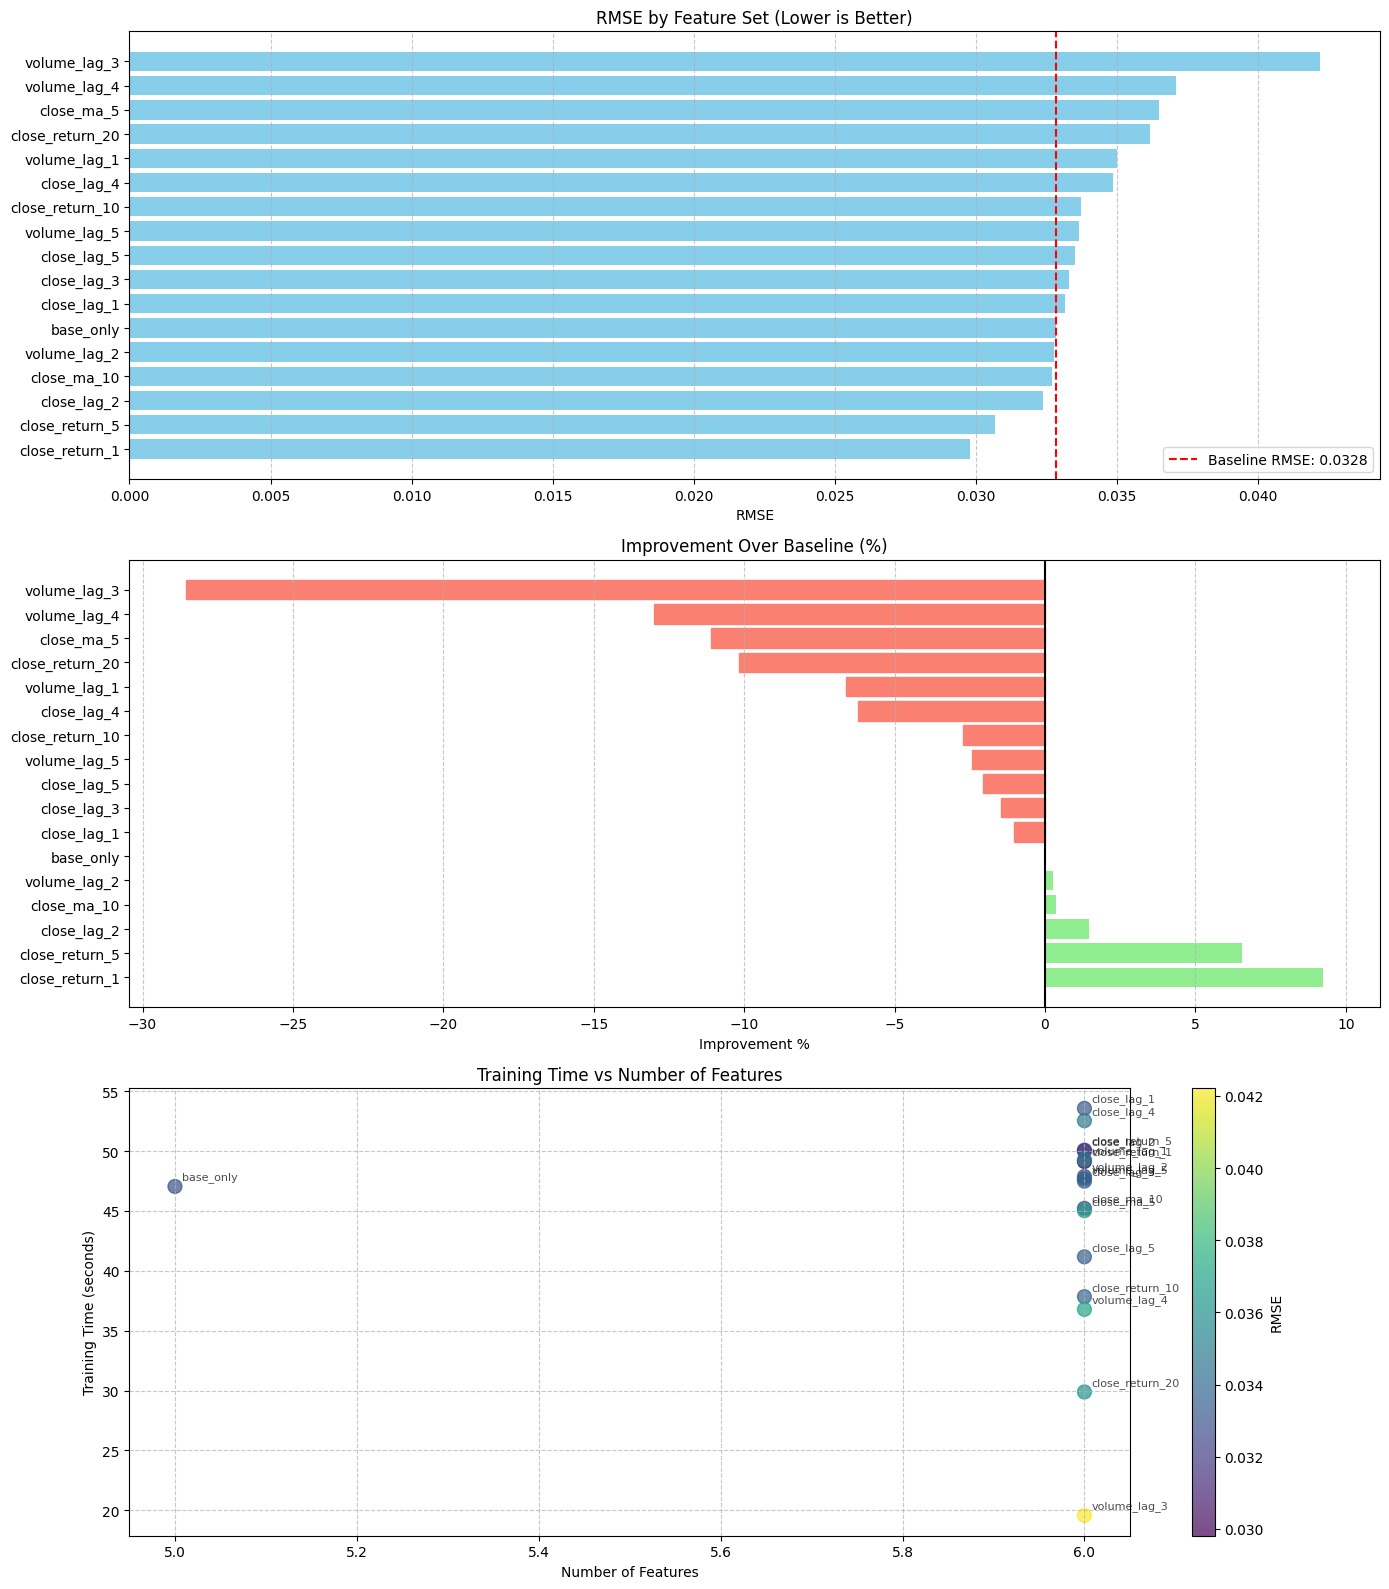


Top 10 Feature Sets:
--------------------------------------------------------------------------------
Rank Feature Set         RMSE      Improv %  Features  Time (s)  
--------------------------------------------------------------------------------
1    close_return_1      0.029808  9.25      6         49.13     
2    close_return_5      0.030691  6.56      6         50.08     
3    close_lag_2         0.032369  1.45      6         50.00     
4    close_ma_10         0.032722  0.38      6         45.22     
5    volume_lag_2        0.032758  0.27      6         47.88     
6    base_only           0.032846  0.00      5         47.05     
7    close_lag_1         0.033179  -1.01     6         53.57     
8    close_lag_3         0.033324  -1.46     6         47.49     
9    close_lag_5         0.033518  -2.05     6         41.17     
10   volume_lag_5        0.033645  -2.43     6         47.69     

Phase 2: Testing combinations of top features...

Evaluating: combined_top_all - Combinat

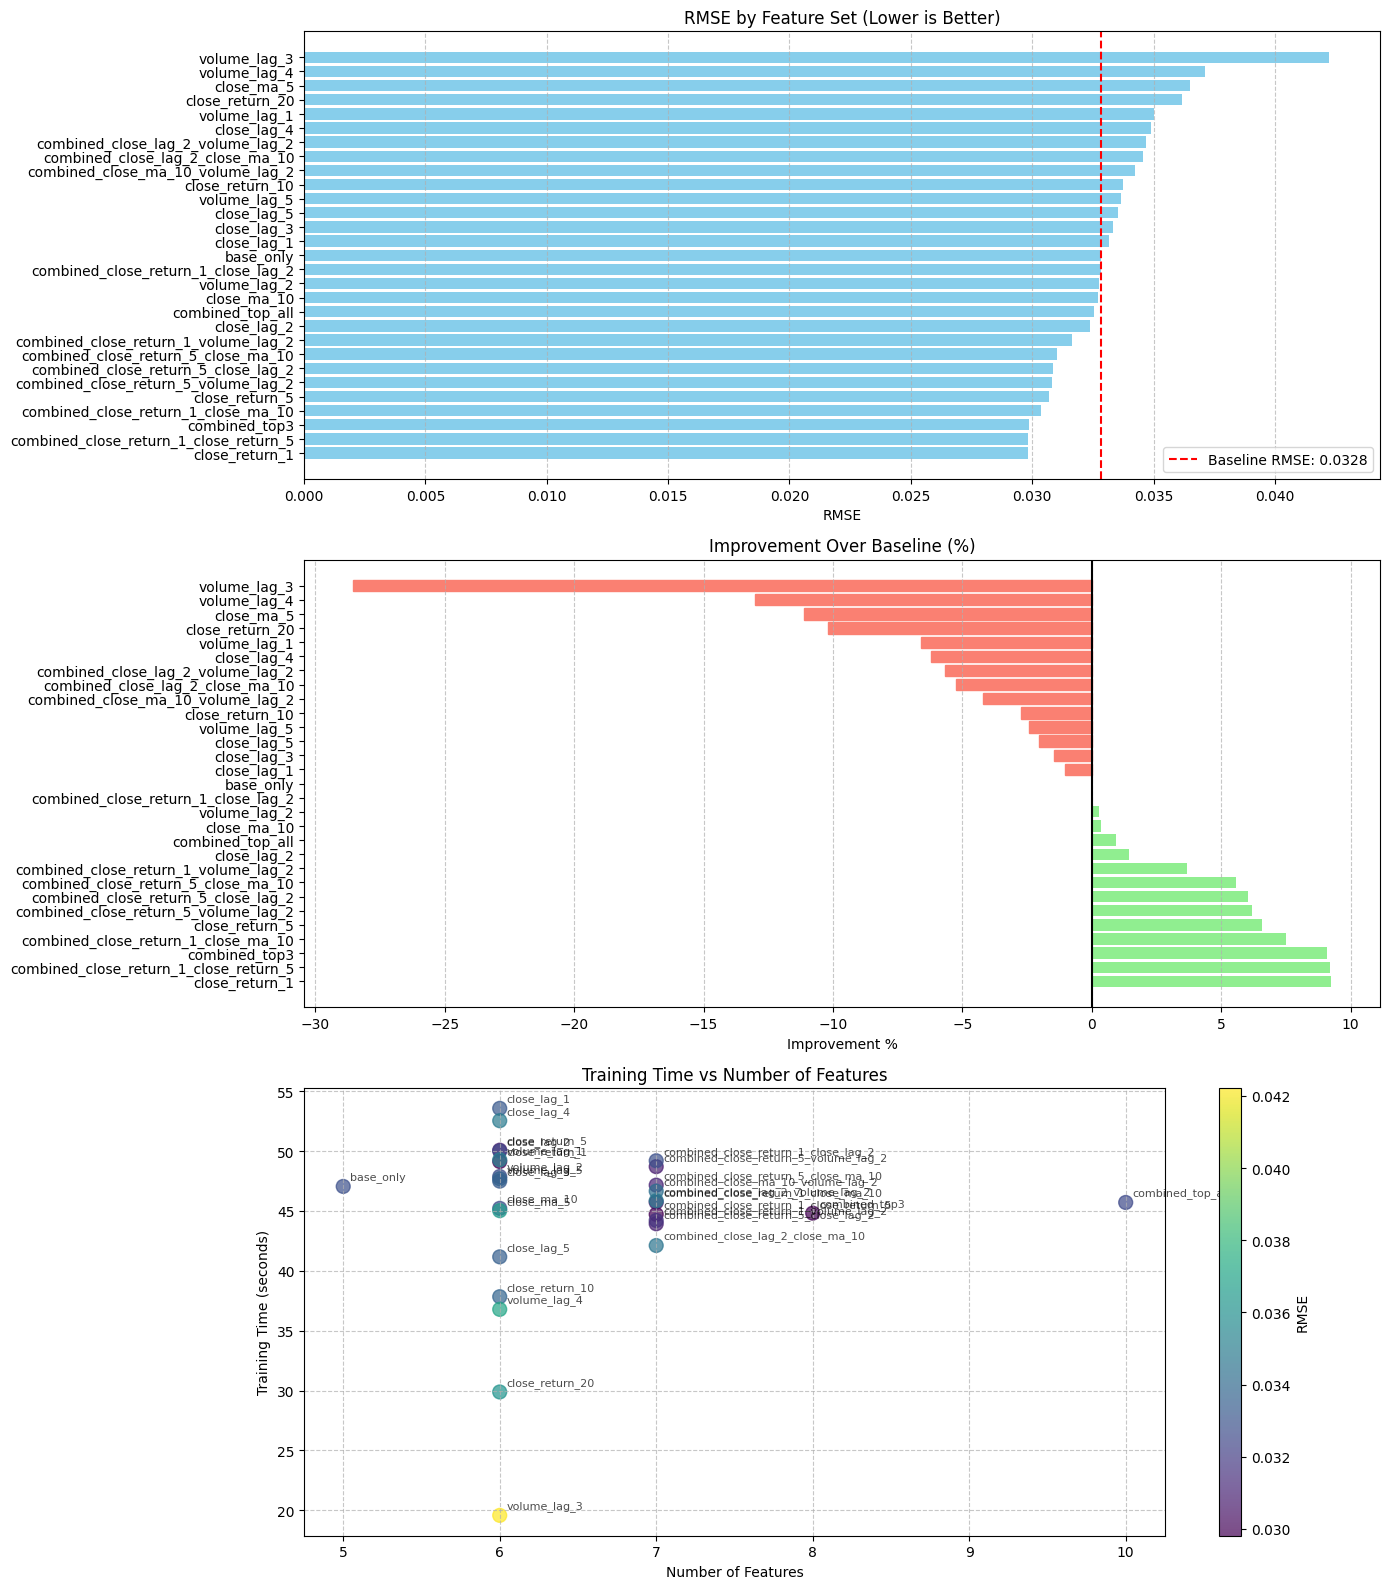


Top 10 Feature Sets:
--------------------------------------------------------------------------------
Rank Feature Set         RMSE      Improv %  Features  Time (s)  
--------------------------------------------------------------------------------
1    close_return_1      0.029808  9.25      6         49.13     
2    combined_close_return_1_close_return_50.029816  9.22      7         44.72     
3    combined_top3       0.029856  9.10      8         44.82     
4    combined_close_return_1_close_ma_100.030374  7.52      7         45.73     
5    close_return_5      0.030691  6.56      6         50.08     
6    combined_close_return_5_volume_lag_20.030810  6.20      7         48.70     
7    combined_close_return_5_close_lag_20.030861  6.04      7         43.93     
8    combined_close_return_5_close_ma_100.031020  5.56      7         47.16     
9    combined_close_return_1_volume_lag_20.031632  3.69      7         44.21     
10   close_lag_2         0.032369  1.45      6         50.00 

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import json

# Your optimal hyperparameters
BEST_CONFIG = {
    'n_steps_in': 30,
    'n_steps_out': 5,
    'epochs': 50,
    'batch_size': 16,
    'lstm_units': 100,
    'dropout_rate': 0.1,
    'learning_rate': 0.001,
    'target_column': 'Close'
}

# Define all possible features with parameter variations
def get_feature_variations():
    """Generate all possible feature variations to test"""
    feature_variations = []

    # 1. Base features (no engineered features)
    feature_variations.append({
        'name': 'base_only',
        'description': 'Base features only (OHLCV)',
        'features': []  # Empty list means use only the base columns
    })

    # 2. Lag features with different parameters
    lag_values = [1, 2, 3, 4, 5]

    for lag in lag_values:
        # Close price lags
        feature_variations.append({
            'name': f'close_lag_{lag}',
            'description': f'Close price lag {lag}',
            'features': [
                {'name': 'close_lag', 'column': 'Close', 'type': 'lag', 'params': {'lag': [lag]}}
            ]
        })

        # Volume lags
        feature_variations.append({
            'name': f'volume_lag_{lag}',
            'description': f'Volume lag {lag}',
            'features': [
                {'name': 'volume_lag', 'column': 'Volume', 'type': 'lag', 'params': {'lag': [lag]}}
            ]
        })

    # 3. Returns with different parameters
    return_periods = [1, 5, 10, 20]

    for period in return_periods:
        feature_variations.append({
            'name': f'close_return_{period}',
            'description': f'Price returns over {period} periods',
            'features': [
                {'name': 'close_return', 'column': 'Close', 'type': 'return', 'params': {'lag': [period]}}
            ]
        })

    # 4. Moving averages with different windows
    ma_windows = [5, 10]

    for window in ma_windows:
        feature_variations.append({
            'name': f'close_ma_{window}',
            'description': f'Simple moving average with window {window}',
            'features': [
                {'name': 'close_ma', 'column': 'Close', 'type': 'ma', 'params': {'window': [window]}}
            ]
        })

    # 5. Exponential moving averages with different spans
    ema_spans = [12, 26]

    for span in ema_spans:
        feature_variations.append({
            'name': f'close_ema_{span}',
            'description': f'Exponential moving average with span {span}',
            'features': [
                {'name': 'close_ema', 'column': 'Close', 'type': 'ema', 'params': {'span': [span]}}
            ]
        })

    # 6. RSI with different windows
    rsi_windows = [9, 14]

    for window in rsi_windows:
        feature_variations.append({
            'name': f'rsi_{window}',
            'description': f'RSI with window {window}',
            'features': [
                {'name': 'rsi', 'column': 'Close', 'type': 'rsi', 'params': {'window': window}}
            ]
        })

    # 7. Bollinger Bands with different windows and standard deviations
    bollinger_windows = [10, 20]
    bollinger_stds = [1.5, 2, 2.5]

    for window in bollinger_windows:
        for std in bollinger_stds:
            feature_variations.append({
                'name': f'bollinger_{window}_{std}',
                'description': f'Bollinger Bands with window {window}, std {std}',
                'features': [
                    {'name': 'bollinger', 'column': 'Close', 'type': 'bollinger', 'params': {'window': window, 'std': std}}
                ]
            })

    # 8. MACD with different parameters
    macd_params = [
        {'fast': 12, 'slow': 26, 'signal': 9},
        {'fast': 8, 'slow': 21, 'signal': 9},
        {'fast': 5, 'slow': 35, 'signal': 5}
    ]

    for i, params in enumerate(macd_params):
        feature_variations.append({
            'name': f'macd_{i+1}',
            'description': f'MACD with fast={params["fast"]}, slow={params["slow"]}, signal={params["signal"]}',
            'features': [
                {'name': 'macd', 'column': 'Close', 'type': 'macd', 'params': params}
            ]
        })

    return feature_variations

# Function to prepare data and evaluate model with specific features
def evaluate_feature_set(df, feature_set, config, log=True):
    """
    Evaluates model performance with a specific feature set

    Args:
        df: Raw DataFrame with price data
        feature_set: Dictionary with feature configuration to test
        config: Model hyperparameters
        log: Whether to print progress logs

    Returns:
        Dictionary with evaluation results
    """
    start_time = time.time()

    if log:
        print(f"\nEvaluating: {feature_set['name']} - {feature_set['description']}")

    # 1. Prepare the base data (always include OHLCV columns)
    base_columns = ['Open', 'High', 'Low', 'Close', 'Volume']

    if not feature_set['features']:  # If empty, use only base columns
        df_featured = df[base_columns].copy()
        if log:
            print("Using only base OHLCV features")
    else:
        # Add the engineered features
        df_featured = engineer_features(df, feature_set['features'])

    # 2. Scale the data
    target_column = config['target_column']

    # Simple scaling function that takes a dataframe of features and returns scaled version
    # plus info about which columns are the target
    def scale_data(data_df, target_col):
        # For this simplified version, we'll use a single scaler for all data
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(data_df)

        # Find the index of the target column
        target_idx = data_df.columns.get_loc(target_col)

        return scaled, scaler, target_idx

    scaled_data, scaler, target_idx = scale_data(df_featured, target_column)

    # 3. Create sequences for LSTM
    def create_sequences(data, n_steps_in, n_steps_out, target_column_idx):
        """Create input sequences and target values"""
        X, y = [], []
        for i in range(len(data) - n_steps_in - n_steps_out + 1):
            # Input sequence (all features)
            X.append(data[i:i + n_steps_in])

            # Target values (only target column - typically Close price)
            y.append(data[i + n_steps_in:i + n_steps_in + n_steps_out, target_column_idx])

        return np.array(X), np.array(y)

    X, y = create_sequences(scaled_data, config['n_steps_in'], config['n_steps_out'], target_idx)

    # 4. Split data
    train_size = int(len(X) * 0.7)
    val_size = int(len(X) * 0.15)

    X_train = X[:train_size]
    y_train = y[:train_size]
    X_val = X[train_size:train_size + val_size]
    y_val = y[train_size:train_size + val_size]
    X_test = X[train_size + val_size:]
    y_test = y[train_size + val_size:]

    # 5. Evaluate model (use a smaller number of epochs for quicker testing)
    if log:
        print(f"Data shape: X_train {X_train.shape}, y_train {y_train.shape}")
        print(f"Number of features: {X_train.shape[2]}")

    # Record data preparation time
    prep_time = time.time() - start_time

    # 6. Build and train LSTM model
    tf_start_time = time.time()

    # Set random seeds for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)

    # Define model building function
    def build_lstm_model(input_shape, output_dim, units, dropout_rate, learning_rate):
        model = tf.keras.Sequential([
            tf.keras.layers.LSTM(units, return_sequences=True, input_shape=input_shape),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.LSTM(units // 2),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(output_dim)
        ])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss='mse'
        )

        return model

    # Build model
    model = build_lstm_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        output_dim=config['n_steps_out'],
        units=config['lstm_units'],
        dropout_rate=config['dropout_rate'],
        learning_rate=config['learning_rate']
    )

    # Reduced epochs for testing efficiency
    reduced_epochs = min(10, config['epochs'])

    # Define callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=reduced_epochs,
        batch_size=config['batch_size'],
        callbacks=callbacks,
        verbose=0  # Silent training
    )

    # Evaluate on validation set
    y_val_pred = model.predict(X_val, verbose=0)

    # Calculate metrics
    val_mse = mean_squared_error(y_val.flatten(), y_val_pred.flatten())
    val_mae = mean_absolute_error(y_val.flatten(), y_val_pred.flatten())
    val_rmse = np.sqrt(val_mse)

    # Get model training time
    train_time = time.time() - tf_start_time

    # Calculate metrics by day (for each step in the prediction horizon)
    day_metrics = {}
    for i in range(y_val.shape[1]):
        day_mse = mean_squared_error(y_val[:, i], y_val_pred[:, i])
        day_mae = mean_absolute_error(y_val[:, i], y_val_pred[:, i])
        day_metrics[f'day_{i+1}'] = {
            'mse': float(day_mse),
            'mae': float(day_mae),
            'rmse': float(np.sqrt(day_mse))
        }

    # Total execution time
    total_time = time.time() - start_time

    # Record results
    results = {
        'feature_set': feature_set['name'],
        'description': feature_set['description'],
        'num_features': X_train.shape[2],
        'val_rmse': float(val_rmse),
        'val_mae': float(val_mae),
        'val_mse': float(val_mse),
        'day_metrics': day_metrics,
        'data_prep_time': float(prep_time),
        'training_time': float(train_time),
        'total_time': float(total_time),
        'epochs_used': len(history.history['loss']),
        'best_val_loss': float(min(history.history['val_loss']))
    }

    if log:
        print(f"RMSE: {val_rmse:.6f}, MAE: {val_mae:.6f}")
        print(f"Training time: {train_time:.2f}s, Total time: {total_time:.2f}s")

    # Clear TF session
    tf.keras.backend.clear_session()

    return results

# Function to run all feature variations
def test_all_features(df, config, max_tests=None):
    """
    Test model performance with different feature sets

    Args:
        df: DataFrame with raw data
        config: Model configuration
        max_tests: Maximum number of tests to run (None = run all)

    Returns:
        List of results for each feature set
    """
    # Create output directory
    if not os.path.exists('feature_tests'):
        os.makedirs('feature_tests')

    # Get all feature variations to test
    feature_sets = get_feature_variations()

    if max_tests is not None:
        feature_sets = feature_sets[:max_tests]

    print(f"Testing {len(feature_sets)} feature variations...")

    # Track all results
    all_results = []

    # First run the baseline (no engineered features)
    baseline_set = next(fs for fs in feature_sets if fs['name'] == 'base_only')
    baseline_result = evaluate_feature_set(df, baseline_set, config)
    all_results.append(baseline_result)

    baseline_rmse = baseline_result['val_rmse']
    print(f"\nBaseline RMSE (OHLCV only): {baseline_rmse:.6f}")

    # Save interim results after baseline
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    with open(f'feature_tests/feature_results_{timestamp}_interim.json', 'w') as f:
        json.dump(all_results, f, indent=2)

    # Test each feature variation
    for i, feature_set in enumerate(feature_sets):
        if feature_set['name'] == 'base_only':
            continue  # Skip baseline since we already tested it

        print(f"\nTesting feature set {i+1}/{len(feature_sets)}: {feature_set['name']}")

        try:
            result = evaluate_feature_set(df, feature_set, config)
            all_results.append(result)

            # Calculate improvement over baseline
            improvement = ((baseline_rmse - result['val_rmse']) / baseline_rmse) * 100

            print(f"RMSE: {result['val_rmse']:.6f}, Change from baseline: {improvement:.2f}%")

            # Save interim results periodically
            if (i + 1) % 5 == 0:
                with open(f'feature_tests/feature_results_{timestamp}_interim.json', 'w') as f:
                    json.dump(all_results, f, indent=2)

        except Exception as e:
            print(f"Error testing {feature_set['name']}: {str(e)}")

    # Save final results
    with open(f'feature_tests/feature_results_{timestamp}_final.json', 'w') as f:
        json.dump(all_results, f, indent=2)

    return all_results

# Function to visualize feature test results
def visualize_feature_results(results):
    """
    Create visualizations of feature test results

    Args:
        results: List of result dictionaries from test_all_features
    """
    # Sort results by RMSE (ascending)
    sorted_results = sorted(results, key=lambda x: x['val_rmse'])

    # Extract data for plotting
    feature_names = [r['feature_set'] for r in sorted_results]
    rmse_values = [r['val_rmse'] for r in sorted_results]
    num_features = [r['num_features'] for r in sorted_results]
    training_times = [r['training_time'] for r in sorted_results]

    # Create figure with multiple subplots
    fig, axes = plt.subplots(3, 1, figsize=(14, 16))

    # 1. RMSE by feature set
    axes[0].barh(feature_names, rmse_values, color='skyblue')
    axes[0].set_title('RMSE by Feature Set (Lower is Better)')
    axes[0].set_xlabel('RMSE')
    axes[0].grid(axis='x', linestyle='--', alpha=0.7)

    # Add baseline reference line
    baseline_rmse = next(r['val_rmse'] for r in results if r['feature_set'] == 'base_only')
    axes[0].axvline(x=baseline_rmse, color='red', linestyle='--',
                   label=f'Baseline RMSE: {baseline_rmse:.4f}')
    axes[0].legend()

    # 2. Improvement percentage over baseline
    improvement = [(baseline_rmse - r['val_rmse']) / baseline_rmse * 100 for r in sorted_results]
    bars = axes[1].barh(feature_names, improvement, color='lightgreen')

    # Color negative values in red
    for i, imp in enumerate(improvement):
        if imp < 0:
            bars[i].set_color('salmon')

    axes[1].set_title('Improvement Over Baseline (%)')
    axes[1].set_xlabel('Improvement %')
    axes[1].grid(axis='x', linestyle='--', alpha=0.7)
    axes[1].axvline(x=0, color='black', linestyle='-')

    # 3. Training time vs Number of features
    sc = axes[2].scatter(num_features, training_times, c=rmse_values, cmap='viridis',
                        alpha=0.7, s=100)

    # Add colorbar
    cbar = plt.colorbar(sc, ax=axes[2])
    cbar.set_label('RMSE')

    # Add annotations for each point
    for i, name in enumerate(feature_names):
        axes[2].annotate(name, (num_features[i], training_times[i]),
                        fontsize=8, alpha=0.7,
                        xytext=(5, 5), textcoords='offset points')

    axes[2].set_title('Training Time vs Number of Features')
    axes[2].set_xlabel('Number of Features')
    axes[2].set_ylabel('Training Time (seconds)')
    axes[2].grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()

    # Save figure
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    plt.savefig(f'feature_tests/feature_comparison_{timestamp}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Also create a summary of the top 10 performing feature sets
    top_n = 10
    print(f"\nTop {top_n} Feature Sets:")
    print("-" * 80)
    print(f"{'Rank':<5}{'Feature Set':<20}{'RMSE':<10}{'Improv %':<10}{'Features':<10}{'Time (s)':<10}")
    print("-" * 80)

    for i, result in enumerate(sorted_results[:top_n]):
        imp = (baseline_rmse - result['val_rmse']) / baseline_rmse * 100
        print(f"{i+1:<5}{result['feature_set']:<20}{result['val_rmse']:<10.6f}{imp:<10.2f}{result['num_features']:<10}{result['training_time']:<10.2f}")

    # Return the top performing feature sets
    return sorted_results[:top_n]

# Function to select best combinations of top features
def create_combined_feature_sets(top_results, original_feature_variations):
    """
    Create combinations of top-performing features to test together

    Args:
        top_results: List of top-performing individual feature results
        original_feature_variations: All original feature variations tested

    Returns:
        List of combination feature sets to test
    """
    # Get number of features to combine (use top 3-5 features)
    top_n = min(5, len(top_results))

    # Get the top feature dictionaries
    top_feature_configs = []
    for result in top_results[:top_n]:
        # Find the original feature configuration
        original_config = next(fv for fv in original_feature_variations if fv['name'] == result['feature_set'])
        top_feature_configs.append(original_config)

    # Create combinations
    combinations = []

    # 1. All top features together
    all_features = []
    for config in top_feature_configs:
        all_features.extend(config['features'])

    combinations.append({
        'name': 'combined_top_all',
        'description': f'Combination of all top {top_n} features',
        'features': all_features
    })

    # 2. Pairs of top features
    if top_n >= 2:
        for i in range(top_n):
            for j in range(i+1, top_n):
                pair_features = []
                pair_features.extend(top_feature_configs[i]['features'])
                pair_features.extend(top_feature_configs[j]['features'])

                combinations.append({
                    'name': f'combined_{top_feature_configs[i]["name"]}_{top_feature_configs[j]["name"]}',
                    'description': f'Combination of {top_feature_configs[i]["name"]} and {top_feature_configs[j]["name"]}',
                    'features': pair_features
                })

    # 3. Top 3 features together (if we have at least 3)
    if top_n >= 3:
        top3_features = []
        for config in top_feature_configs[:3]:
            top3_features.extend(config['features'])

        combinations.append({
            'name': 'combined_top3',
            'description': 'Combination of top 3 features',
            'features': top3_features
        })

    return combinations

# Main function to run the feature testing process
def feature_importance_main():
    """Main function to run feature importance testing"""
    print("Starting feature importance testing...")

    # 1. Load data
    df = load_data('cleaned_data.csv')
    if df is None:
        print("Error loading data. Exiting.")
        return

    # 2. Test base features first, then add one feature at a time
    print("\nPhase 1: Testing individual features...")
    all_feature_variations = get_feature_variations()

    # Optionally limit number of tests for faster iteration
    max_tests = None  # Set to a number or None for all tests

    # Run tests for individual features
    phase1_results = test_all_features(df, BEST_CONFIG, max_tests)

    # 3. Visualize and analyze individual feature results
    top_features = visualize_feature_results(phase1_results)

    # 4. Test combinations of the best features
    print("\nPhase 2: Testing combinations of top features...")
    combination_sets = create_combined_feature_sets(top_features, all_feature_variations)

    # Run tests for combinations
    combination_results = []
    for combo_set in combination_sets:
        try:
            result = evaluate_feature_set(df, combo_set, BEST_CONFIG)
            combination_results.append(result)
            print(f"Combo: {combo_set['name']}, RMSE: {result['val_rmse']:.6f}")
        except Exception as e:
            print(f"Error testing {combo_set['name']}: {str(e)}")

    # 5. Combine individual and combination results
    all_results = phase1_results + combination_results

    # 6. Final analysis and visualization
    print("\nFinal Analysis:")
    best_sets = visualize_feature_results(all_results)

    # 7. Output the optimal feature set
    best_feature_set = best_sets[0]['feature_set']
    print(f"\nOptimal feature set: {best_feature_set}")

    # Find the feature configuration for the best set
    if 'combined' in best_feature_set:
        best_config = next(cs for cs in combination_sets if cs['name'] == best_feature_set)
    else:
        best_config = next(fv for fv in all_feature_variations if fv['name'] == best_feature_set)

    print("\nFeatures to include in final model:")
    if best_config['features']:
        for feature in best_config['features']:
            print(f"- {feature}")
    else:
        print("- Base features only (OHLCV)")

    # Return the best feature configuration
    return best_config

# Helper functions (simplified versions that should match your existing implementations)
def load_data(file_path):
    try:
        df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
        print(f"Data loaded successfully. Shape: {df.shape}")
        return df
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None

def engineer_features(df, features_list):
    """
    Engineer features based on the provided configuration list.
    This is a simplified placeholder - implement your actual feature engineering logic here.
    """
    # Start with all columns from original dataframe
    result_df = df.copy()

    # Process each feature
    for feature in features_list:
        feature_type = feature['type']
        column = feature['column']

        if feature_type == 'lag':
            # Add lagged values
            for lag in feature['params']['lag']:
                result_df[f'{column}_lag_{lag}'] = result_df[column].shift(lag)

        elif feature_type == 'return':
            # Calculate returns
            for lag in feature['params']['lag']:
                result_df[f'{column}_return_{lag}'] = result_df[column].pct_change(lag)

        elif feature_type == 'ma':
            # Calculate moving averages
            for window in feature['params']['window']:
                result_df[f'{column}_ma_{window}'] = result_df[column].rolling(window=window).mean()

        elif feature_type == 'ema':
            # Calculate exponential moving averages
            for span in feature['params']['span']:
                result_df[f'{column}_ema_{span}'] = result_df[column].ewm(span=span, adjust=False).mean()

        elif feature_type == 'rsi':
            # Calculate RSI
            window = feature['params']['window']
            delta = result_df[column].diff()
            gain = delta.where(delta > 0, 0)
            loss = -delta.where(delta < 0, 0)
            avg_gain = gain.rolling(window=window).mean()
            avg_loss = loss.rolling(window=window).mean()
            rs = avg_gain / avg_loss
            result_df[f'{column}_rsi_{window}'] = 100 - (100 / (1 + rs))

        elif feature_type == 'bollinger':
            # Calculate Bollinger Bands
            window = feature['params']['window']
            std = feature['params']['std']
            ma = result_df[column].rolling(window=window).mean()
            std_dev = result_df[column].rolling(window=window).std()
            result_df[f'{column}_bollinger_upper_{window}_{std}'] = ma + (std_dev * std)
            result_df[f'{column}_bollinger_lower_{window}_{std}'] = ma - (std_dev * std)
            result_df[f'{column}_bollinger_pct_{window}_{std}'] = (result_df[column] - ma) / (std_dev * std)

        elif feature_type == 'macd':
            # Calculate MACD
            fast = feature['params']['fast']
            slow = feature['params']['slow']
            signal = feature['params']['signal']

            fast_ema = result_df[column].ewm(span=fast, adjust=False).mean()
            slow_ema = result_df[column].ewm(span=slow, adjust=False).mean()
            macd_line = fast_ema - slow_ema
            signal_line = macd_line.ewm(span=signal, adjust=False).mean()

            result_df[f'{column}_macd_line_{fast}_{slow}'] = macd_line
            result_df[f'{column}_macd_signal_{fast}_{slow}_{signal}'] = signal_line
            result_df[f'{column}_macd_hist_{fast}_{slow}_{signal}'] = macd_line - signal_line

    # Drop NaN values created by rolling windows and lag features
    result_df = result_df.dropna()

    return result_df

# Run the main function
if __name__ == "__main__":
    feature_importance_main()